In [1]:
import mne
from pathlib import Path
data_path = r"data\first_try\mati\mati_test_real_movement_1_annotated.fif"
recording_name = Path(data_path).stem
is_real_movement = "real" in data_path.lower()
recording_type = "real_movement" if is_real_movement else "motor_imagery"

raw = mne.io.read_raw_fif(data_path, preload=True)
eeg_channels = ["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10", "A11", "A12", "A13", "A14", "A15", "A16"]
raw.pick(picks=eeg_channels)
raw.resample(sfreq=250)
raw.filter(l_freq=1.0, h_freq=40.0, fir_design='firwin')
raw.notch_filter(freqs=[50.0])

mateusz_mapping = {
    'A1': 'Fp1',
    'A2': 'Fp2',
    'A3': 'F4',
    'A4': 'Fz',
    'A5': 'F3',
    'A6': 'T7',
    'A7': 'C3',
    'A8': 'Cz',
    'A9': 'C4',
    'A10': 'T8',
    'A11': 'P4',
    'A12': 'Pz',
    'A13': 'P3',
    'A14': 'O1',
    'A15': 'Oz',
    'A16': 'O2'
}

hania_mapping = {
    'A1': 'Fp1',
    'A2': 'Fp2',
    'A3': 'F4',
    'A4': 'Fz',
    'A5': 'F3',
    'A6': 'CP1', # modified
    'A7': 'C3', 
    'A8': 'Cz',
    'A9': 'C4',
    'A10': 'CP2', # modified
    'A11': 'P4',
    'A12': 'Pz',
    'A13': 'P3',
    'A14': 'FC1', # modified
    'A15': 'CPz', # modified // not sure if this is exactly correct
    'A16': 'FC2' # modified
}

raw.rename_channels(mateusz_mapping)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

all_events, all_events_id = mne.events_from_annotations(raw)
all_events_id = {'Both feets': 1, 'Both hands': 2, 'Left hand': 3, 'Relax': 4, 'Right hand': 5}

if 'Relax' in all_events_id:
    relax_event_id = {'Relax': all_events_id['Relax']}
    del all_events_id['Relax']

task_margin = 1.0 # seconds, margin to be sure that we are focused on the task
task_end = 9.0 # seconds, to have same length for all epochs
epochs = mne.Epochs(
    raw=raw,
    events=all_events,
    event_id=all_events_id,
    baseline=None,
    tmin=task_margin,
    tmax=task_end,
    preload=True
)

task_end = 4.0
relax_epochs = mne.Epochs(
    raw=raw,
    events=all_events,
    event_id=relax_event_id,
    baseline=None,
    tmin=task_margin,
    tmax=task_end,
    preload=True
)


Opening raw data file data\first_try\mati\mati_test_real_movement_1_annotated.fif...
Isotrak not found
    Range : 0 ... 538623 =      0.000 ...   263.000 secs
Ready.
Reading 0 ... 538623  =      0.000 ...   263.000 secs...


C:\Users\Mateuusz\AppData\Local\Temp\ipykernel_21684\341467907.py:8: RuntimeWarning: This filename (data\first_try\mati\mati_test_real_movement_1_annotated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(data_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge

### Split epochs into overlapping segments
Currently I rely on moabb implementation for validation, so train/test data split is not really used, but store it as future reference. 

In [2]:
from tools import split_epochs_into_segments, merge_epochs

split_factor = 0.8
test_end = int(len(epochs) * split_factor)
test_epochs, train_epochs = epochs[:test_end], epochs[test_end:] 
print(epochs)
print(test_epochs)
print(train_epochs)
segment_length = 1.0  # seconds
step = 1.0  # seconds
splitted_test_epochs = split_epochs_into_segments(test_epochs, segment_length, step)
splitted_train_epochs = split_epochs_into_segments(train_epochs, segment_length, step)

test_relax_end = int(len(relax_epochs) * split_factor)
test_relax_epochs, train_relax_epochs = relax_epochs[:test_relax_end], relax_epochs[test_relax_end:] 
splitted_test_relax_epochs = split_epochs_into_segments(test_relax_epochs, segment_length, step)
splitted_train_relax_epochs = split_epochs_into_segments(train_relax_epochs, segment_length, step)

splitted_test_epochs = merge_epochs(splitted_test_epochs, splitted_test_relax_epochs)
splitted_train_epochs = merge_epochs(splitted_train_epochs, splitted_train_relax_epochs)

all_epochs = merge_epochs(splitted_train_epochs, splitted_test_epochs)
print(splitted_test_epochs)
all_epochs_filename = f"{recording_name}_epochs_splitted-epo.fif"
all_epochs.save(f"data/processed/{all_epochs_filename}", overwrite=True)

<Epochs | 16 events (all good), 1 – 9 s (baseline off), ~3.9 MiB, data loaded,
 'Both feets': 4
 'Both hands': 4
 'Left hand': 4
 'Right hand': 4>
<Epochs | 12 events (all good), 1 – 9 s (baseline off), ~3.0 MiB, data loaded,
 'Both feets': 3
 'Both hands': 3
 'Left hand': 3
 'Right hand': 3>
<Epochs | 4 events (all good), 1 – 9 s (baseline off), ~1.0 MiB, data loaded,
 'Both feets': 1
 'Both hands': 1
 'Left hand': 1
 'Right hand': 1>
{'Both feets': 1, 'Both hands': 2, 'Left hand': 3, 'Right hand': 5}
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
{'Both feets': 1, 'Both hands': 2, 'Left hand': 3, 'Right hand': 5}
Not setting metadata
32 matching events found
No baseline correction applied
0 projection items activated
{'Relax': 4}
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated
{'Relax': 4}
Not setting metadata
12 matching events found
No baseline correction applied
0 p

[WindowsPath('d:/STUDIA/ZPB2/3. Data gathering/data/processed/mati_test_real_movement_1_annotated_epochs_splitted-epo.fif')]

### Read saved epochs

Reading d:\STUDIA\ZPB2\3. Data gathering\data\processed\mati_test_real_movement_1_annotated_epochs_splitted-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
176 matching events found
No baseline correction applied
0 projection items activated
Using matplotlib as 2D backend.


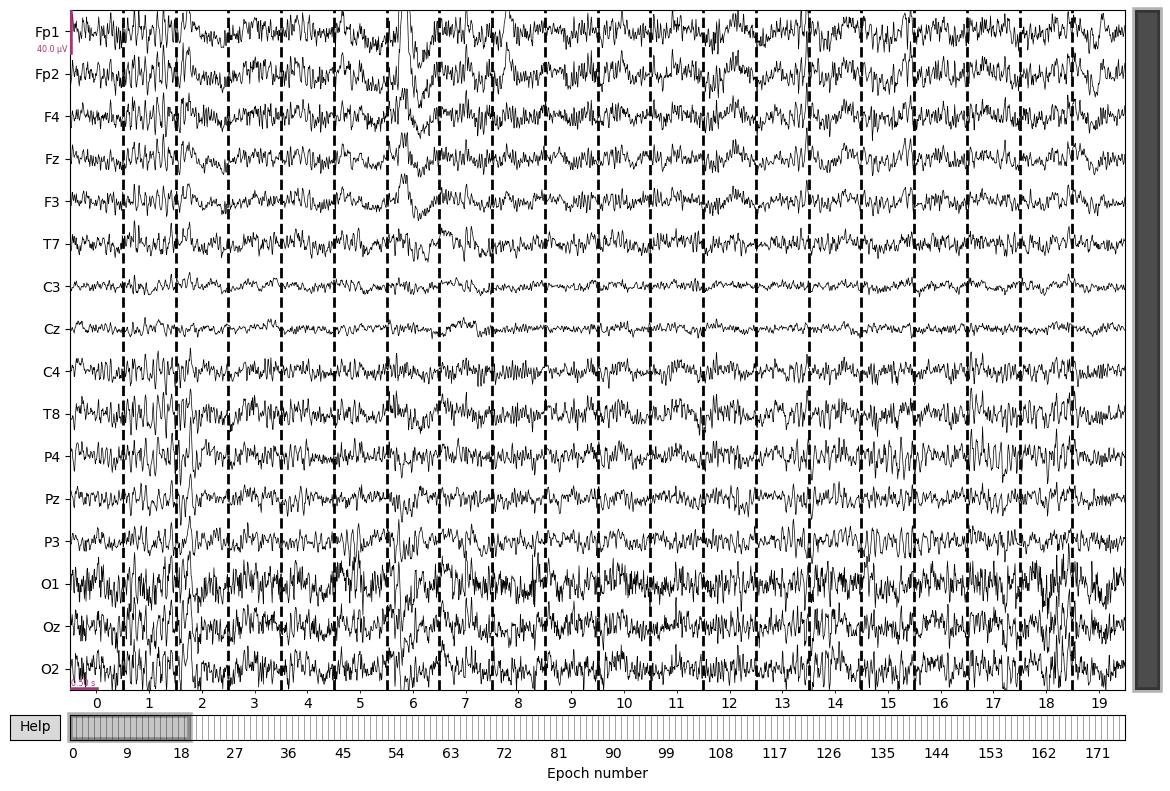

In [3]:
epochs_from_file = mne.read_epochs(f"data/processed/{recording_name}_epochs_splitted-epo.fif")
epochs_from_file.plot()
pass

In [4]:
import os
import numpy as np
import mne
from moabb.datasets.base import BaseDataset

class BrainBotDataset(BaseDataset):
    def __init__(self, data_dir, subjects, events, interval, data_names, sessions_per_subject):
        """
        Parameters
        ----------
        data_dir : str
            Path to the directory containing the data files.
        subjects : list
            List of subject identifiers.
        events : dict
            Dictionary mapping event names to event IDs.
        interval : list
            Time interval for epochs.
        data_names : dict
            Dictionary mapping subject identifiers to their corresponding data file names (can be multiple runs).
        sessions_per_subject : int
            Number of sessions per subject.
        """
        super().__init__(
            subjects=subjects,
            sessions_per_subject=sessions_per_subject,
            events=events,
            code="BrainBot",
            interval=interval,
            paradigm="imagery",
        )
        self.data_dir = data_dir
        self.data_names = data_names

    def data_path(self, subject, path=None, force_update=False, update_path=None, verbose=None):
        base = self.data_dir
        filenames = self.data_names[subject]
        epochs_files = [os.path.join(base, fname) for fname in filenames]
        return epochs_files

    def _get_single_subject_data(self, subject):
        paths = self.data_path(subject)
        sessions = {"0": {}} # sessions->runs->raw
        for i, path in enumerate(paths):
            epochs = mne.read_epochs(path, preload=True)
            data = epochs.get_data()
            n_epochs, n_ch, n_times = data.shape
            data_flat = data.transpose(1, 0, 2).reshape(n_ch, n_epochs * n_times)

            # create stim channel for moabb compatibility
            stim = np.zeros(n_epochs * n_times, dtype=int)
            for i, ev in enumerate(epochs.events):
                sample = i * n_times
                stim[sample] = int(ev[2])
            data_with_stim = np.vstack([data_flat, stim])

            sfreq = all_epochs.info['sfreq']
            ch_names = all_epochs.ch_names + ['stim']
            ch_types = ['eeg'] * n_ch + ['stim']
            info = mne.create_info(ch_names, sfreq, ch_types)
            raw = mne.io.RawArray(data_with_stim, info)
            sessions["0"][str(i)] = raw
        
        return sessions

dataset = BrainBotDataset(
    data_dir="data/processed/",
    subjects=[0, 1], # 0 - hania, 1 - mati
    events=all_epochs.event_id,
    interval=[0.0, 2.0],
    data_names={
        0: [
            'hania_imagery_movement_1_annotated_epochs_splitted_segment=2.0-step=1.0-epo.fif',
            'hania_imagery_movement_2_annotated_epochs_splitted_segment=2.0-step=1.0-epo.fif',
            'hania_imagery_movement_2_annotated_epochs_splitted_segment=2.0-step=1.0-epo.fif', # X: repeated to have 3 sessions
        ],
        1: [
            'mati_test_imagery_movement_1_annotated_epochs_splitted_segment=2.0-step=1.0-epo.fif',
            'mati_test_imagery_movement_2_squeezing_ball_annotated_epochs_splitted_segment=2.0-step=1.0-epo.fif',
            'mati_test_imagery_movement_3_lifting_fingers_annotated_epochs_splitted_segment=2.0-step=1.0-epo.fif',
        ],
    },
    sessions_per_subject=3,
)

The dataset class name 'BrainBotDataset' must be an abbreviation of its code 'BrainBot'. See moabb.datasets.base.is_abbrev for more information.


In [5]:
from moabb.datasets import BNCI2014_001, PhysionetMI, Schirrmeister2017, Zhou2016
from moabb.paradigms import MotorImagery, LeftRightImagery
from moabb.evaluations import WithinSessionEvaluation

from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from mne.decoding import CSP

import moabb

moabb.set_log_level('ERROR')
mne.set_log_level('ERROR')

datasets = [dataset]
paradigm = MotorImagery(n_classes=5)

# Base classifiers and preprocessing
svm = OneVsRestClassifier(SVC(kernel='rbf', probability=True))
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

pipelines = {}
# Keep original pipelines for reference
pipelines['CSP + SVM'] = make_pipeline(csp, svm)
pipelines['CSP + LDA'] = make_pipeline(CSP(n_components=8), LinearDiscriminantAnalysis())

from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

# TGSP (Riemannian) pipeline
pipelines['TGSP + SVM'] = make_pipeline(Covariances("oas"), TangentSpace(metric="riemann"), SVC(kernel="linear", probability=True))

# Calibrate SVM (wrap OneVsRestClassifier). Calibration improves predict_proba quality for voting/stacking
calibrated_svm = CalibratedClassifierCV(estimator=OneVsRestClassifier(SVC(kernel='rbf', probability=True)), cv=3)
pipelines['CSP + SVM (Cal)'] = make_pipeline(CSP(n_components=4, reg=None, log=True, norm_trace=False), calibrated_svm)
pipelines['TGSP + SVM (Cal)'] = make_pipeline(Covariances("oas"), TangentSpace(metric="riemann"), CalibratedClassifierCV(estimator=SVC(kernel="linear", probability=True), cv=3))

# Build explicit ordered list of base estimators for ensembles
base_estimators = [
    ('csp_svm_cal', pipelines['CSP + SVM (Cal)']),
    ('csp_lda', pipelines['CSP + LDA']),
    ('tgsp_svm_cal', pipelines['TGSP + SVM (Cal)']),
]

# Weighted voting: favor the stronger models
voting = VotingClassifier(estimators=base_estimators, voting='soft', weights=[1, 2, 2])
pipelines['Ensemble (Weighted)'] = voting

# Stacking with a regularized meta-learner (smaller C => stronger regularization)
stacking = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(C=0.1, max_iter=1000), cv=5, stack_method='predict_proba')
pipelines['Stacking (All+RegLR)'] = stacking

evaluation = WithinSessionEvaluation(paradigm=paradigm, datasets=datasets, overwrite=True)
results = evaluation.process(pipelines)

BrainBot-WithinSession:   0%|          | 0/2 [00:00<?, ?it/s]d:\STUDIA\ZPB2\2. Models\.venv2\Lib\site-packages\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 180 events (all good), 0 – 2 s (baseline off), ~11.0 MiB, data loaded,
 'Both feets': 34
 'Both hands': 42
 'Left hand': 35
 'Right hand': 28
 'Relax': 41>
  warn(f"warnEpochs {epochs}")
d:\STUDIA\ZPB2\2. Models\.venv2\Lib\site-packages\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 187 events (all good), 0 – 2 s (baseline off), ~11.5 MiB, data loaded,
 'Both feets': 34
 'Both hands': 35
 'Left hand': 35
 'Right hand': 42
 'Relax': 41>
  warn(f"warnEpochs {epochs}")


No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.


BrainBot-WithinSession:  50%|█████     | 1/2 [00:43<00:43, 43.75s/it]d:\STUDIA\ZPB2\2. Models\.venv2\Lib\site-packages\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 178 events (all good), 0 – 2 s (baseline off), ~10.9 MiB, data loaded,
 'Both feets': 34
 'Both hands': 35
 'Left hand': 35
 'Right hand': 35
 'Relax': 39>
  warn(f"warnEpochs {epochs}")
d:\STUDIA\ZPB2\2. Models\.venv2\Lib\site-packages\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 180 events (all good), 0 – 2 s (baseline off), ~11.0 MiB, data loaded,
 'Both feets': 34
 'Both hands': 35
 'Left hand': 35
 'Right hand': 35
 'Relax': 41>
  warn(f"warnEpochs {epochs}")


No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.


BrainBot-WithinSession: 100%|██████████| 2/2 [01:30<00:00, 45.27s/it]


In [6]:
print("Results Summary:")
summary = results.groupby(['pipeline', 'dataset'])['score'].agg(['mean', 'std', 'count'])
summary['mean'] = summary['mean'].round(3)
summary['std'] = summary['std'].round(3)
print(summary.to_string())
print("=" * 50)

print("\nDetailed Results by Subject and Dataset:")
detailed = results.pivot_table(
    index=['dataset', 'subject', 'session'], 
    columns='pipeline', 
    values='score'
)
print(detailed.round(3).to_string())
print("=" * 50)

Results Summary:
                                mean    std  count
pipeline             dataset                      
CSP + LDA            BrainBot  0.425  0.027      2
CSP + SVM            BrainBot  0.388  0.067      2
CSP + SVM (Cal)      BrainBot  0.363  0.034      2
Ensemble (Weighted)  BrainBot  0.471  0.037      2
Stacking (All+RegLR) BrainBot  0.422  0.051      2
TGSP + SVM           BrainBot  0.619  0.009      2
TGSP + SVM (Cal)     BrainBot  0.536  0.064      2

Detailed Results by Subject and Dataset:
pipeline                  CSP + LDA  CSP + SVM  CSP + SVM (Cal)  Ensemble (Weighted)  Stacking (All+RegLR)  TGSP + SVM  TGSP + SVM (Cal)
dataset  subject session                                                                                                                
BrainBot 0       0            0.406      0.436            0.387                0.444                 0.458       0.613             0.490
         1       0            0.444      0.340            0.338        